In [1]:
! hostname
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np

a00610.science.domain


In [3]:
# import the python scripts in this folder
import sys
sys.path.append("./erda/deep_contact")
from unet_model import UNet
from hdf5_dataset import SimulationHdf5Dataset

In [12]:
from pathlib import Path
# we pull the dataset onto local storage if it's not there:
SIMDATA='erda/data/2dsim/xml1515100_res0.125_h0.5.hdf5'
SIMDATA_tmp='/tmp/xml1515100_res0.125_h0.5.hdf5'

if not Path(SIMDATA_tmp).exists():
    !cp  SIMDATA SIMDATA_tmp

In [13]:
# define some constants
PATH = Path('erda/data/2dsim')
# batch size
bs=64

In [14]:
import pickle
# compute dataset statistics and save them
ds = SimulationHdf5Dataset(SIMDATA)
SIMDATA_stats = SIMDATA + '_stats.pkl'
if not Path(SIMDATA_stats).exists():
    # pull the dataset in memory
    X,Y = ds[:,:,:,:]
    stats= {}
    stats['X_mean'] = np.mean(X,axis=(0,2,3))
    stats['X_std'] = np.std(X,axis=(0,2,3))
    stats['Y_mean'] = np.mean(Y,axis=(0,2,3))
    stats['Y_std'] = np.std(Y,axis=(0,2,3))
    with open(SIMDATA_stats, 'wb') as f:
        pickle.dump(stats, f, pickle.HIGHEST_PROTOCOL)
    # clear the loaded dataset. We will use the dataloaders to access it.
    del X,Y
else :
    with open(SIMDATA_stats, 'rb') as f:
        stats = pickle.load(f)
stats

{'X_mean': array([ 0.00536,  0.00067, -0.00024, -0.01445, -0.00012,  0.00027], dtype=float32),
 'X_std': array([0.01276, 0.00159, 0.01406, 0.06313, 0.01683, 0.03144], dtype=float32),
 'Y_mean': array([0.00007, 0.00071, 0.0042 , 0.00001], dtype=float32),
 'Y_std': array([0.01149, 0.01338, 0.02493, 0.00592], dtype=float32)}

In [15]:
from fastai.dataset import *

# train-validation-test split
SIMDATA_split = SIMDATA + '_splits.pkl'
if not Path(SIMDATA_split).exists():
    val_idxs = get_cv_idxs(len(ds),val_pct=0.08) # 10% of the data for the test set
    test_idxs,tr_idxs = split_by_idx(val_idxs,np.arange(len(ds)))[0]
    # 20% of the remaining for validation, rest for train
    val_idxs = get_cv_idxs(len(tr_idxs),val_pct=0.2) 
    val_idxs, tr_idxs = split_by_idx(val_idxs,tr_idxs)[0]

    split={}
    split['train_idxs'],split['val_idxs'],split['test_idxs']=tr_idxs,val_idxs,test_idxs
    del tr_idxs, val_idxs, test_idxs
    with open(SIMDATA_split, 'wb') as f:
        pickle.dump(split, f, pickle.HIGHEST_PROTOCOL)
else :
    with open(SIMDATA_split, 'rb') as f:
        split = pickle.load(f)
len(ds),[s.shape for s in split.values()]

(13822, [(10174,), (2543,), (1105,)])

In [17]:

# reverse the index of the dataset
body_channels = {k: v for k, v in zip(ds.body_channels,range(len(ds.body_channels)))}
contact_channels = {k: v for k, v in zip(ds.contact_channels,range(len(ds.contact_channels)))}


### select the channels that we use from training
create selector functions for the 2 cases that we use

the format is N_examples x N_channels x H x W.

Depending on the case we want to train for, run either of the cells

In [18]:
# what do we use as input to the NN?
b_idxs = [body_channels['mass'],
          body_channels['inertia'],
          body_channels['vx'],
          body_channels['vy'],
          body_channels['omega']]
# what are we trying to predict?
c_idxs = [contact_channels['ni'],
          contact_channels['ti']]

def get_data(ds,i):
    X=ds[i][0][b_idxs]
    Y=ds[i][1][c_idxs]
#     import pdb;pdb.set_trace()
    return X, Y

X_mean = stats['X_mean'][b_idxs]
X_std = stats['X_std'][b_idxs]
Y_mean = stats['Y_mean'][c_idxs]
Y_std = stats['Y_std'][c_idxs]

# get_data(ds,69)

In [8]:
# with temporal information
# TODO: add flags array at beginning of each simulation
# so that we know to add black image to the input tensor

# what do we use as input to the NN?
b_idxs = [body_channels['mass'],
          body_channels['inertia'],
          body_channels['vx'],
          body_channels['vy'],
          body_channels['omega']],
c_idxs = [contact_channels['ni'],
          contact_channels['ti']]

def get_data(ds,i):

    Y_prev = ds[i-1][1][c_idxs]
    X=ds[i][0][b_idxs]
    
    X=np.concatenate([X,Y_prev])
    Y=ds[i][1][c_idxs]
    return X,Y

X_mean = np.concatenate([stats['X_mean'][b_idxs],stats['Y_mean'][c_idxs]])
X_std = np.concatenate([stats['X_std'][b_idxs],stats['Y_std'][c_idxs]])
Y_mean = stats['Y_mean'][c_idxs]
Y_std = stats['Y_std'][c_idxs]

In [19]:
from torchvision.transforms import *

class Tensorize(object):
    def __call__(self, pic):
        return torch.from_numpy(pic).float()

    def __repr__(self):
        return self.__class__.__name__ + '()'

class PadToSize(object):
    def __call__(self,pic):
        return np.pad(pic,((0,0),(3,4),(3,4)),'constant')
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

class Norm(object):
    def __init__(self,mean,std):
        self.mean=mean
        self.std=std
        
    def __call__(self,pic):
        pic = (np.moveaxis(pic, 0, -1) - self.mean)/self.std
        return np.moveaxis(pic, -1, 0)
    
    def __repr__(self):
        return self.__class__.__name__ + '()'


class DeepContactDataset(Dataset):
    def __init__(self):
        self.tensorize=Tensorize()
        self.pad = PadToSize()
        self.norm_x = Norm(mean=X_mean, std=X_std)
        self.norm_y= Norm(mean=Y_mean, std=Y_std)
    
    def __getitem__(self, index):
        X,Y=get_data(ds, index);
        X=self.pad(X)
        X=self.norm_x(X)
        X=self.tensorize(X)
        
        Y=self.pad(Y)
        Y=self.norm_y(Y)
        Y=self.tensorize(Y)
        
        return X,Y

    def __len__(self):
        return len(ds)

In [20]:
from torch.utils.data.dataset import Subset
dcds = DeepContactDataset()

train_loader = torch.utils.data.DataLoader(dataset=Subset(dcds,split['train_idxs']),
                          batch_size=bs,
                          shuffle=True,
                          num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=Subset(dcds,split['val_idxs']),
                          batch_size=bs,
                          shuffle=False,
                          num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=Subset(dcds,split['test_idxs']),
                          batch_size=bs,
                          shuffle=False,
                          num_workers=8)

In [11]:
from fastai.conv_learner import *

md = ModelData(path=PATH,trn_dl=train_loader, val_dl=val_loader, test_dl=test_loader)
net = UNet(5,2)
learn = Learner.from_model_data(m=net, data=md)
learn.crit = F.mse_loss

In [13]:
learn.lr_find()

 96%|█████████▌| 153/159 [14:19<00:33,  5.55s/it, loss=12.2] 

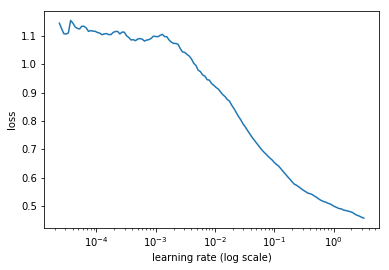

In [14]:
learn.sched.plot()

In [14]:
lr=0.5
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                               
    0      0.874306   0.879377  
    1      0.572602   0.464126                               
    2      0.437376   0.366504                               
    3      0.36672    0.331453                               
    4      0.333893   0.307717                               


[array([0.30772])]

In [15]:
learn.save("3mar_5epochs_03loss")

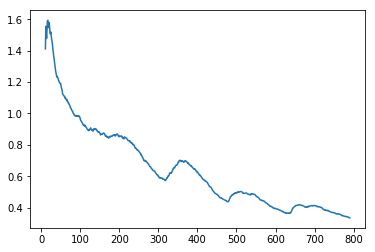

In [16]:
learn.sched.plot_loss()

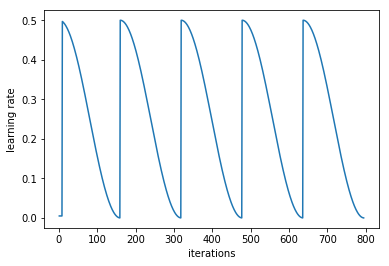

In [17]:
learn.sched.plot_lr()

In [18]:
learn.fit(lr, 1, cycle_len=5)

epoch      trn_loss   val_loss                               
    0      0.350139   0.413165  
    1      0.330089   0.337079                               
    2      0.321606   0.305029                               
    3      0.300088   0.288273                               
    4      0.28923    0.287392                               


[array([0.28739])]

In [20]:
learn.save("3mar_10epochs_028loss")

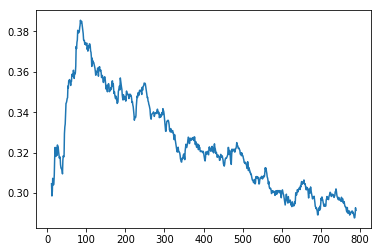

In [21]:
learn.sched.plot_loss()

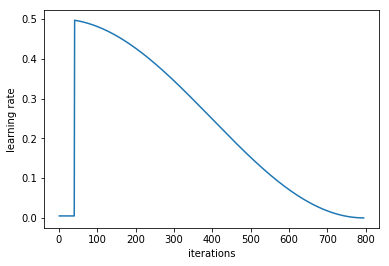

In [22]:
learn.sched.plot_lr()

In [24]:
learn.fit(lr, 1, cycle_len=10)

epoch      trn_loss   val_loss                               
    0      0.332512   0.32575   
    1      0.240822   0.292459                               
    2      0.058036   0.073461                                
    3      0.032982   0.009592                                
    4      0.043803   0.01685                                 
    5      0.027056   0.007061                                
    6      0.027688   0.005607                                
    7      0.023932   0.005541                                
    8      0.016601   0.004775                                
    9      0.015347   0.005798                                


[array([0.0058])]

In [25]:
learn.save("3mar_20epochs_final")

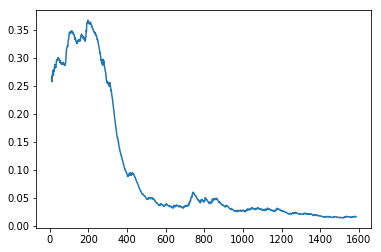

In [26]:
learn.sched.plot_loss()

## Train UNet with temporal information: 

In [11]:
from fastai.conv_learner import *

md = ModelData(path=PATH,trn_dl=train_loader, val_dl=val_loader, test_dl=test_loader)
net = UNet(7,2)
learn = Learner.from_model_data(m=net, data=md)
learn.crit = F.mse_loss

In [12]:
learn.lr_find()

 97%|█████████▋| 154/159 [07:25<00:13,  2.62s/it, loss=4.96] 

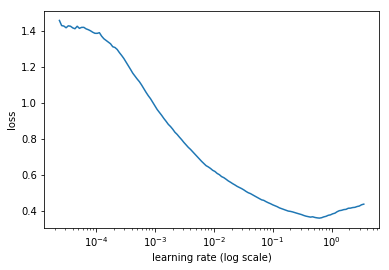

In [14]:
learn.sched.plot()

In [15]:
lr=0.05
learn.fit(lr, 5,cycle_len=1)

epoch      trn_loss   val_loss                               
    0      0.277132   0.250648  
    1      0.163144   0.134856                               
    2      0.057425   0.037207                                
    3      0.036737   0.020445                                
    4      0.026227   0.013352                                


[array([0.01335])]

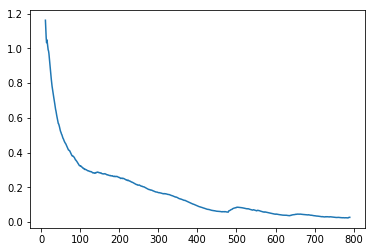

In [16]:
learn.sched.plot_loss()

In [17]:
learn.save("4mar_temporal_5epochs_002loss")

In [18]:
learn.fit(lr, 1, cycle_len=5)

epoch      trn_loss   val_loss                                
    0      0.035567   0.080777  
    1      0.01902    0.009175                                
    2      0.018789   0.007539                                
    3      0.015658   0.007083                                
    4      0.017099   0.006907                                


[array([0.00691])]

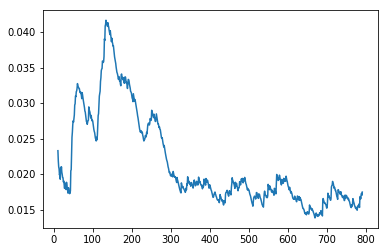

In [19]:
learn.sched.plot_loss()

In [20]:
learn.save("4mar_temporal_10epochs_final")

In [12]:
learn.load("4mar_temporal_10epochs_final")
lr=0.05

In [14]:
learn.fit(lr, 1,cycle_len=10)

epoch      trn_loss   val_loss                                
    0      0.018946   0.007049  
    1      0.015451   0.006607                                
    2      0.017115   0.008057                                
    3      0.017272   0.007563                                
    4      0.013061   0.006001                                
    5      0.01646    0.005603                                
    6      0.01811    0.006206                                
    7      0.017584   0.005805                                
    8      0.013203   0.006515                                
    9      0.01445    0.006177                                


[array([0.00618])]

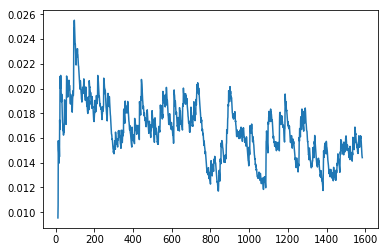

In [15]:
learn.sched.plot_loss()

In [16]:
learn.save("4mar_temporal_20epochs_final")